# Chapter 3 : Classification

In Chapter 1 we mentioned that the most common supervised learning tasks are
regression (predicting values) and classification (predicting classes). In Chapter 2 we
explored a regression task, predicting housing values, using various algorithms such
as Linear Regression, Decision Trees, and Random Forests (which will be explained
in further detail in later chapters). Now we will turn our attention to classification
systems.

## The MNIST dataset

In this chapter, we will be using the MNIST dataset, which is a set of 70,000 small
images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “Hello World” of Machine Learning: whenever
people come up with a new classification algorithm, they are curious to see how it
will perform on MNIST. Whenever someone learns Machine Learning, sooner or
later they tackle MNIST

![](https://machinelearningmastery.com/wp-content/uploads/2019/02/Plot-of-a-Subset-of-Images-from-the-MNIST-Dataset.png)

Scikit-Learn provides many helper functions to download popular datasets. MNIST is
one of them. The following code fetches the MNIST dataset:

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Explore inputs and outputs:

In [ ]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Show a sample image from the dataset : reshape the pixels to 28x28 !

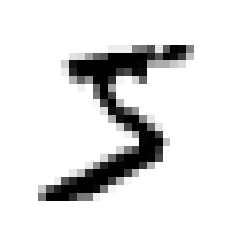

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)

plt.show()

View the corresponding label of the showen image

In [ ]:
y[0]

'5'

We can notice that the label was given as a string! convert it to int :

In [ ]:
import numpy as np

y = y.astype(np.uint8)
print(y[0])

5


Select 10,000 images for test and 60,000 images for train

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for
this classification task:


In [ ]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

Okay, now let’s pick a classifier and train it. A good place to start is with a Stochastic
Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently.
This is in part because SGD deals with training instances independently, one at a time
(which also makes SGD well suited for online learning), as we will see later. Let’s create
an SGDClassifier and train it on the whole training set:

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=9)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=9)

Now you can use it to detect images of the number 5:

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right
in this particular case! Now, let’s evaluate this model’s performance.

## Performance Measures


Evaluating a classifier is often significantly trickier than evaluating a regressor, so we
will spend a large part of this chapter on this topic. There are many performance measures available, so grab another coffee and get ready to learn many new concepts
and acronyms!


### Measuring Accuracy Using Cross-Validation


A good way to evaluate a model is to use cross-validation, just as we did in Chapter 2.


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,scoring="accuracy",cv=3)

array([0.962  , 0.96535, 0.96495])

Wow! Above 90% accuracy (ratio of correct predictions) on all cross-validation folds? 
This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very
dumb classifier that just classifies every single image in the “not-5” class:

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
 def fit(self, X, y=None):
  pass
 def predict(self, X):
  return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
#Run Cross Validation with never 5 classifier
cross_val_score(never_5_clf,X_train,y_train_5,scoring="accuracy",cv=3)

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure
for classifiers

### Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are
classified as class B. For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion
matrix

To compute the confusion matrix, you first need to have a set of predictions, so they
can be compared to the actual targets. You could make predictions on the test set, but
let’s keep it untouched for now (remember that you want to use the test set only at the
very end of your project, once you have a classifier that you are ready to launch).
Instead, you can use the cross_val_predict() function.

Just like the cross_val_score() function, cross_val_predict() performs K-fold
cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.


In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes (y_train_5) and the predicted classes
(y_train_pred):

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,y_train_pred)

array([[54079,   500],
       [ 1654,  3767]])

Each row in a confusion matrix represents an actual class, while each column repre‐
sents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,057 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 1,522 were wrongly classified as 5s (false positives).
The second row considers the images of 5s (the positive class): 1,325 were wrongly
classified as non-5s (false negatives), while the remaining 4,096 were correctly classified as 5s (true positives). A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [ ]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5,y_train_5)

array([[54579,     0],
       [    0,  5421]])

The confusion matrix gives you a lot of information, but sometimes you may prefer a
more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the classifier.

TP is the number of true positives, and FP is the number of false positives.

A trivial way to have perfect precision is to make one single positive prediction and
ensure it is correct (precision = 1/1 = 100%). This would not be very useful since the
classifier would ignore all but one positive instance. So precision is typically used
along with another metric named recall, also called sensitivity or true positive rate.
FN is of course the number of false negatives.

![](https://miro.medium.com/max/824/1*xMl_wkMt42Hy8i84zs2WGg.png)

Calculate Precision and recall from confusion matrix

In [ ]:
confusion_matrix(y_train_5, y_train_pred)

array([[54079,   500],
       [ 1654,  3767]])

In [ ]:
cm = confusion_matrix(y_train_5, y_train_pred)
precision = cm[1,1] / (cm[1,1] + cm[0,1])
recall = cm[1,1] / (cm[1,1] + cm[1,0])

print("prec",precision,"recall",recall)

prec 0.8828216545582377 recall 0.6948902416528315


Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:


In [ ]:
from sklearn.metrics import precision_score, recall_score

print("precision:",precision_score(y_train_5, y_train_pred))
print("recall:",recall_score(y_train_5, y_train_pred))

precision: 0.8828216545582377
recall: 0.6948902416528315


Now your 5-detector does not look as shiny as it did when you looked at its accuracy.

It is often convenient to combine precision and recall into a single metric called the F1
score, in particular if you need a simple way to compare two classifiers. The F1
 score is 
the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.
As a result, the classifier will only get a high F1
 score if both recall and precision are
high.

<img src="https://datascience103579984.files.wordpress.com/2019/04/capture3-24.png" height = 150/>

In [ ]:
from sklearn.metrics import f1_score

print("f1_score",f1_score(y_train_5, y_train_pred))

f1_score 0.77766308835673


The F1
score favors classifiers that have similar precision and recall. This is not always
what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect
shoplifters on surveillance images: it is probably fine if your classifier has only 30%
precision as long as it has 99% recall (sure, the security guards will get a few false
alerts, but almost all shoplifters will get caught).
Unfortunately, you can’t have it both ways: increasing precision reduces recall, and
vice versa. This is called the precision/recall tradeoff.

## Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also
called multinomial classifiers) can distinguish between more than two classes.

one way to create a system that can classify the digit images into 10
classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a
1-detector, a 2-detector, and so on). Then when you want to classify an image, you get
the decision score from each classifier for that image and you select the class whose
classifier outputs the highest score. This is called the one-versus-all (OvA) strategy 
(also called one-versus-the-rest).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
This is called the one-versus-one (OvO) strategy. If there are N classes, you need to
train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45
binary classifiers! When you want to classify an image, you have to run the image
through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training
set for the two classes that it must distinguish.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for
which it uses OvO). Let’s try this with the SGDClassifier:

In [ ]:
y[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [ ]:
some_digit = X[0]
sgd_clf.fit(X_train, y_train) 
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

That was easy! This code trains the SGDClassifier on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-all target classes
(y_train_5). Then it makes a prediction (a correct one in this case). Under the hood,
Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the
image, and selected the class with the highest score.
To see that this is indeed the case, you can call the decision_function() method.
Instead of returning just one score per instance, it now returns 10 scores, one per class:

In [ ]:
# Get decisions from classifier for some digit
some_digit_scores =  sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-13805.29931575, -31807.06273982,  -8700.11308457,
           745.12896185, -17328.08897781,   4822.3943465 ,
        -15831.42048265, -13723.09626341, -10814.92898366,
         -5156.74807764]])

Get classes 

In [ ]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

get output index

In [ ]:
np.argmax(some_digit_scores)

5

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use
the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance
and pass a binary classifier to its constructor. For example, this code creates a multiclass classifier using the OvO strategy, based on a SGDClassifier:

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

In [ ]:
len(ovo_clf.estimators_)


In [ ]:
ovo_clf.decision_function([X[178]])

In [ ]:
np.argmax(ovo_clf.decision_function([X[178]]))

In [ ]:
plot_digit(X[178])

In [ ]:
y[178]

Now of course you want to evaluate these classifiers. As usual, you want to use crossvalidation. Let’s evaluate the SGDClassifier’s accuracy using the cross_val_score()
function:


In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

It gets over 84% on all test folds. If you used a random classifier, you would get 10%
accuracy, so this is not such a bad score, but you can still do much better. For example, simply scaling the inputs (as discussed in Chapter 2) increases accuracy above
89%:

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = #Normalize the images
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90225, 0.896  , 0.89935])

## Error Analysis

Of course, if this were a real project, you would follow the steps in your Machine
Learning project checklist: exploring data preparation options, trying out
multiple models, shortlisting the best ones and fine-tuning their hyperparameters
using GridSearchCV, and automating as much as possible, as you did in the previous
chapter. Here, we will assume that you have found a promising model and you want
to find ways to improve it. One way to do this is to analyze the types of errors it
makes.
First, you can look at the confusion matrix. You need to make predictions using the
cross_val_predict() function, then call the confusion_matrix() function, just like
you did earlier:

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

That’s a lot of numbers. It’s often more convenient to look at an image representation
of the confusion matrix, using Matplotlib’s matshow() function:


In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks fairly good, since most images are on the main diagonal,
which means that they were classified correctly. The 5s look slightly darker than the
other digits, which could mean that there are fewer images of 5s in the dataset or that
the classifier does not perform as well on 5s as on other digits. In fact, you can verify
that both are the case.
Let’s focus the plot on the errors. First, you need to divide each value in the confusion
matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors (which would make abundant classes look
unfairly bad)

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result:


In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Now you can clearly see the kinds of errors the classifier makes. Remember that rows
represent actual classes, while columns represent predicted classes. The column for
class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily
symmetrical. You can also see that 3s and 5s often get confused (in both directions).


Analyzing individual errors can also be a good way to gain insights on what your
classifier is doing and why it is failing, but it is more difficult and time-consuming.


In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

## Multilabel Classification


Until now each instance has always been assigned to just one class. In some cases you
may want your classifier to output multiple classes for each instance. For example,
consider a face-recognition classifier: what should it do if it recognizes several people
on the same picture? Of course it should attach one tag per person it recognizes. Say
the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then
when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning
“Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple
binary tags is called a multilabel classification system.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = # Use KNN Classifier
knn_clf.fit(X_train, y_multilabel)

This code creates a y_multilabel array containing two target labels for each digit
image: the first indicates whether or not the digit is large (7, 8, or 9) and the second
indicates whether or not it is odd. The next lines create a KNeighborsClassifier
instance (which supports multilabel classification, but not all classifiers do) and we
train it using the multiple targets array. Now you can make a prediction, and notice
that it outputs two labels:

In [ ]:
knn_clf.predict([some_digit])

And it gets it right! The digit 5 is indeed not large (False) and odd (True).
There are many ways to evaluate a multilabel classifier, and selecting the right metric
really depends on your project. For example, one approach is to measure the F1
 score
for each individual label (or any other binary classifier metric discussed earlier), then
simply compute the average score. This code computes the average F1
score across all
labels:

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")